## <center><font color='purple'> Diabetes Prediction - Dynamic Ensemble Selection [Tutorial]</font></center> 
#### <center> Firuz Juraev (SKKU) </center>

### <font color='purple'> Libraries 

In [1]:
import pandas as pd 
import numpy as np 
import random
import seaborn as sns 
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#### <font color='blue'> Libraries for Preprocessing 

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

#### <font color='blue'> Libraries for Single ML models 

In [3]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

#### <font color='blue'> Libraries for Metrics

In [4]:
from sklearn.metrics import (accuracy_score,
                             precision_score,
                             recall_score, 
                             f1_score)

#### <font color='blue'> Libraries for DES

In [5]:
from deslib.des import DESP
from deslib.des import KNORAE
from deslib.des import KNORAU
from deslib.des import KNOP

In [6]:
def side_by_side(*objs, **kwds):
    from pandas.io.formats.printing import adjoin
    space = kwds.get('space', 4)
    reprs = [repr(obj).split('\n') for obj in objs]
    print (adjoin(space, *reprs))
    print()
    return

#### <font color='blue'> Libraries for XAI

In [7]:
import shap

In [8]:
import scipy.stats as stats

### <font color='purple'> Loading Dataset </font>

#### Dataset 
> **Pima Indians Diabetes Database** - This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.


* https://www.kaggle.com/uciml/pima-indians-diabetes-database?select=diabetes.csv

In [9]:
diabetes_data = pd.read_csv("datasets/diabetes.csv")

#### <font color='blue'> Dataset Info 

In [10]:
num_rows = diabetes_data.shape[0]
print('Dataset contains '+str(num_rows)+' rows.')
num_cols = diabetes_data.shape[1]
print('Dataset contains '+str(num_cols)+' columns.')

Dataset contains 768 rows.
Dataset contains 9 columns.


In [11]:
diabetes_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [12]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


#### Missing Data

In [13]:
for i,c in enumerate(diabetes_data.columns):
    na_percent = np.sum(diabetes_data[c].isnull())/len(diabetes_data)*100
    if na_percent > 0:
        print(c,'\t\t% Missing(N/A) = ',np.sum(diabetes_data[c].isnull())/len(diabetes_data)*100)

In [14]:
side_by_side(diabetes_data.isnull().sum(), diabetes_data.count())

Pregnancies                 0    Pregnancies                 768
Glucose                     0    Glucose                     768
BloodPressure               0    BloodPressure               768
SkinThickness               0    SkinThickness               768
Insulin                     0    Insulin                     768
BMI                         0    BMI                         768
DiabetesPedigreeFunction    0    DiabetesPedigreeFunction    768
Age                         0    Age                         768
Outcome                     0    Outcome                     768
dtype: int64                     dtype: int64                   



***We don't have any missing data***

#### <font color='blue'> Data Visualization 

Counts of each class
0    500
1    268
Name: Outcome, dtype: int64


(768, 9)

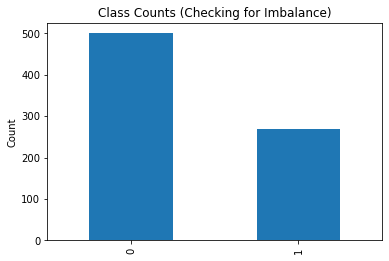

In [15]:
print("Counts of each class")
print(diabetes_data["Outcome"].value_counts())
diabetes_data["Outcome"].value_counts().plot(kind='bar')
plt.ylabel('Count')
plt.title('Class Counts (Checking for Imbalance)')
diabetes_data.shape

<AxesSubplot:xlabel='Outcome', ylabel='Pregnancies'>

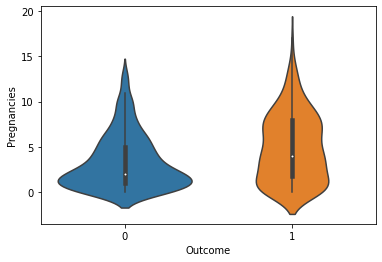

In [16]:
sns.violinplot(x="Outcome", y="Pregnancies", data=diabetes_data)

**Observations!** From the figure above we can see that women who have many pregnancies have higher potential to be diabete

<AxesSubplot:xlabel='Outcome', ylabel='BloodPressure'>

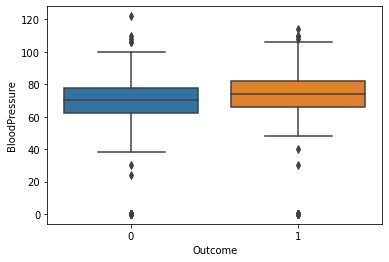

In [17]:
sns.boxplot(x="Outcome", y="BloodPressure", data=diabetes_data)

#### <font color='blue'> Feature Correlation 

In [18]:
diabetes_data.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

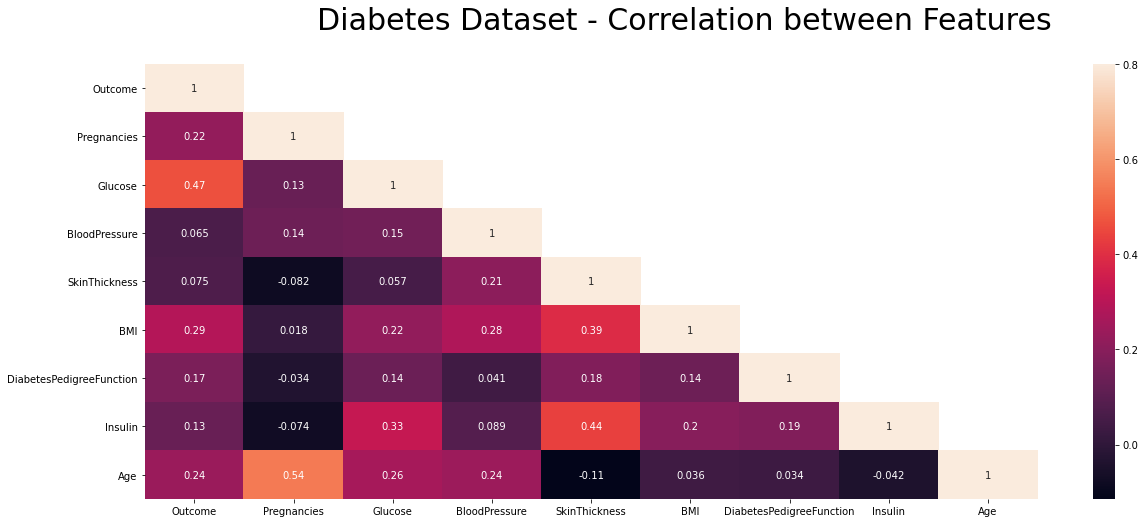

In [19]:
fig,ax = plt.subplots(figsize=(20,8))
fig.suptitle("Diabetes Dataset - Correlation between Features", fontsize=30)
corrcoef = diabetes_data[['Outcome', 'Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness',
                          'BMI', 'DiabetesPedigreeFunction', 'Insulin', 'Age']].corr()
mask = np.array(corrcoef)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
plt.show();

***********************

### <font color='blue'> Outlier Detection

#### <font color='blue'> Z-SCORE </font>

> Using Z score method,we can find out how many standard deviations value away from the mean.
* 68% of the data points lie between + or - 1 standard deviation.
* 95% of the data points lie between + or - 2 standard deviation
* 99.7% of the data points lie between + or - 3 standard deviation

<img src='images/z_score_formula.png'>

<img src="images/normal_destrub.jpg" style="width:400px; heigh:200px">

In [20]:
def z_score_outlier(df):
    out=[] 
    m = np.mean(df)
    sd = np.std(df)
    for i in df: 
        z = (i-m)/sd
        if np.abs(z) > 3: 
            out.append(i)
    print("Outliers:",out)

In [21]:
z = (0-120.89)/(31.97)
print(z)

-3.7813575226775105


In [22]:
z_score_outlier(diabetes_data['Glucose'])

Outliers: [0, 0, 0, 0, 0]


In [23]:
z_score_outlier(diabetes_data['DiabetesPedigreeFunction'])

Outliers: [2.288, 1.893, 1.781, 2.329, 1.476, 2.137, 1.731, 1.6, 2.42, 1.699, 1.698]


In [24]:
diabetes_data['DiabetesPedigreeFunction'].describe()

count    768.000000
mean       0.471876
std        0.331329
min        0.078000
25%        0.243750
50%        0.372500
75%        0.626250
max        2.420000
Name: DiabetesPedigreeFunction, dtype: float64

In [25]:
diabetes_data[diabetes_data['DiabetesPedigreeFunction'] >=1.6]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
4,0,137,40,35,168,43.1,2.288,33,1
45,0,180,66,39,0,42.0,1.893,25,1
58,0,146,82,0,0,40.5,1.781,44,0
228,4,197,70,39,744,36.7,2.329,31,0
370,3,173,82,48,465,38.4,2.137,25,1
371,0,118,64,23,89,0.0,1.731,21,0
395,2,127,58,24,275,27.7,1.600,25,0
445,0,180,78,63,14,59.4,2.420,25,1
593,2,82,52,22,115,28.5,1.699,25,0
621,2,92,76,20,0,24.2,1.698,28,0


#### <font color='blue'>ROBUST Z-SCORE </font>

> It is also called as Median absolute deviation method. It is similar to Z-score method with some changes in parameters. Since mean and standard deviations are heavily influenced by outliers, alter to this parameters we use median and absolute deviation from median.

<img src='images/robust_z_score_formula.png'>

In [26]:
def ZRscore_outlier(df):
    out = []
    med = np.median(df)
    ma = stats.median_absolute_deviation(df)
    for i in df: 
        z = (0.6745*(i-med))/ (np.median(ma))
        if np.abs(z) > 3: 
            out.append(i)
    print("Outliers:",out)
    print("number of outliers:", len(out))

In [27]:
ZRscore_outlier(diabetes_data['Glucose'])

Outliers: []
number of outliers: 0


In [28]:
ZRscore_outlier(diabetes_data['BloodPressure'])

Outliers: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
number of outliers: 35


In [29]:
ZRscore_outlier(diabetes_data['DiabetesPedigreeFunction'])

Outliers: [2.288, 1.893, 1.781, 2.329, 2.137, 1.731, 1.6, 2.42, 1.699, 1.698]
number of outliers: 10


In [30]:
ZRscore_outlier(diabetes_data['BMI'])

Outliers: [0.0, 0.0, 0.0, 0.0, 0.0, 67.1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
number of outliers: 12


In [31]:
diabetes_data['BMI'].describe().T

count    768.000000
mean      31.992578
std        7.884160
min        0.000000
25%       27.300000
50%       32.000000
75%       36.600000
max       67.100000
Name: BMI, dtype: float64

In [32]:
ZRscore_outlier(diabetes_data['Insulin'])

Outliers: [543, 846, 235, 245, 240, 300, 342, 304, 270, 495, 325, 284, 485, 285, 495, 318, 280, 271, 478, 744, 370, 680, 402, 258, 375, 278, 545, 360, 255, 249, 325, 293, 465, 325, 285, 415, 275, 579, 310, 474, 277, 237, 328, 250, 480, 265, 326, 274, 330, 600, 293, 272, 321, 440, 540, 240, 265, 480, 335, 387, 291, 392, 510]
number of outliers: 63


> **Observation**: As you can see from the results above we have many ouliers 

___________________________________________

In [33]:
diabetes_data.drop(['Insulin'], axis=1, inplace=True)

In [34]:
diabetes_data = diabetes_data[diabetes_data['DiabetesPedigreeFunction'] < 1.6]

______________________

####  <font color='blue'> Splitting the dataset into training and testing 

In [35]:
y = diabetes_data['Outcome']
X = diabetes_data.drop(['Outcome'], axis=1)

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=40)

In [37]:
X_train.shape

(568, 7)

#### <font color='blue'> Data Normalization 

In [38]:
Min_max_scaler = MinMaxScaler().fit(X_train)

## Scaling 
X_train_mm_scaled = Min_max_scaler.transform(X_train)
X_test_mm_scaled = Min_max_scaler.transform(X_test)

## Numpy Array to DataFrame 
df_train_mm_scaled = pd.DataFrame(X_train_mm_scaled)
df_test_mm_scaled = pd.DataFrame(X_test_mm_scaled)

### <font color='purple'> Single ML Model

In [39]:
def get_results(train_x, train_y, test_x, test_y, classifiers): 
    names = []
    accuracy_list = [] 
    precision_list = []
    recall_list = [] 
    f1_list = []
    
    for cls in classifiers: 
        cls.fit(train_x, train_y)
        y_preds = cls.predict(test_x) 
        
        accuracy = round(cls.score(test_x, test_y), 3) 
        precision = round(precision_score(y_test, y_preds), 3)
        recall = round(recall_score(y_test, y_preds), 3)
        f1 = round(f1_score(y_test, y_preds), 3)
        
        names.append(cls.__class__.__name__)
        accuracy_list.append(accuracy)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)
    
    results = {'Models': names, 
               'Accuracy': accuracy_list, 
               'Precision': precision_list, 
               'Recall': recall_list, 
               'F1': f1_list}
    
    resultsDF = pd.DataFrame.from_dict(results)
    
    return resultsDF

In [40]:
model_nb = GaussianNB(var_smoothing=0.001)
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_svc = SVC(kernel="linear")

classifiers = [model_nb, model_lr, model_dt, model_svc]

In [41]:
results = get_results(X_train_mm_scaled, y_train, X_test_mm_scaled, y_test, classifiers)

In [42]:
results

,Models,Accuracy,Precision,Recall,F1
0,GaussianNB,0.716,0.597,0.561,0.578
1,LogisticRegression,0.753,0.667,0.576,0.618
2,DecisionTreeClassifier,0.753,0.661,0.591,0.624
3,SVC,0.763,0.678,0.606,0.640


### <font color='purple'> Explainable AI (XAI)

In [43]:
model_dt.fit(X_train, y_train)

explainer = shap.TreeExplainer(model_dt)  
shap_values = explainer.shap_values(X_test)
base_value = explainer.expected_value
explainer

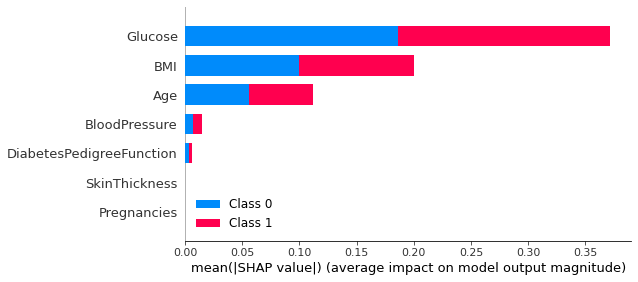

In [44]:
shap.summary_plot(shap_values, X_test_mm_scaled, title="SHAP summary plot for Decision Tree Classifier", 
                  feature_names=X_test.columns) 

In [45]:
model_lr.fit(X_train, y_train)

LogisticRegression()

Text(0.5, 0, 'Importance')

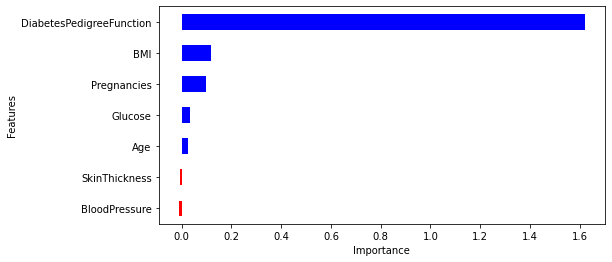

In [46]:
coeff = list(model_lr.coef_[0])
labels = list(diabetes_data.drop('Outcome',1).columns)
 
features = pd.DataFrame()
features['Features'] = labels
features['importance'] = coeff
features.sort_values(by=['importance'], ascending=True, inplace=True)
features['positive'] = features['importance'] > 0
features.set_index('Features', inplace=True)
features.importance.plot(kind='barh', figsize=(8, 4),color = features.positive.map({True: 'blue', False: 'red'}))
plt.xlabel('Importance')

### <font color='purple'> DES with Single ML models pool 

In [47]:
rng = np.random.RandomState(42) 
X_train, X_dsel, y_train_en, y_dsel = train_test_split(X_train_mm_scaled, y_train, test_size=0.40, random_state=rng)

In [48]:
model_nb = GaussianNB(var_smoothing=0.001)
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_svc = SVC(kernel="linear")

model_nb.fit(X_train, y_train_en)
model_lr.fit(X_train, y_train_en)
model_dt.fit(X_train, y_train_en)
model_svc.fit(X_train, y_train_en) 

pool_classifiers = [model_nb, model_lr, model_dt, model_svc]

desp = DESP(pool_classifiers)
knorau = KNORAU(pool_classifiers)
kne = KNORAE(pool_classifiers)  

des_models = [desp, knorau, kne]

des_results = get_results(X_dsel, y_dsel, X_test_mm_scaled, y_test, des_models)

In [49]:
des_results

,Models,Accuracy,Precision,Recall,F1
0,DESP,0.779,0.761,0.530,0.625
1,KNORAU,0.784,0.766,0.545,0.637
2,KNORAE,0.789,0.760,0.576,0.655


### <font color='purple'> FIRE-DES with Single ML models pool 

> 

* Paper Link: https://www.etsmtl.ca/Unites-de-recherche/LIVIA/Recherche-et-innovation/Publications/Publications-2017/Oliveira_PR_2017.pdf 

In [50]:
model_nb = GaussianNB(var_smoothing=0.001)
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_svc = SVC(kernel="linear")

model_nb.fit(X_train, y_train_en)
model_lr.fit(X_train, y_train_en)
model_dt.fit(X_train, y_train_en)
model_svc.fit(X_train, y_train_en) 

pool_classifiers = [model_nb, model_lr, model_dt, model_svc]

desp = DESP(pool_classifiers, DFP=True)
knorau = KNORAU(pool_classifiers, DFP=True)
kne = KNORAE(pool_classifiers, DFP=True)  

des_models = [desp, knorau, kne]

des_results = get_results(X_dsel, y_dsel, X_test_mm_scaled, y_test, des_models)

In [51]:
kne.fit(X_dsel, y_dsel)

KNORAE(DFP=True,
       pool_classifiers=[GaussianNB(var_smoothing=0.001), LogisticRegression(),
                         DecisionTreeClassifier(criterion='entropy',
                                                max_depth=3),
                         SVC(kernel='linear')])

In [52]:
kne.score(X_test_mm_scaled, y_test)

0.7947368421052632

In [53]:
des_results

,Models,Accuracy,Precision,Recall,F1
0,DESP,0.784,0.755,0.561,0.643
1,KNORAU,0.774,0.725,0.561,0.632
2,KNORAE,0.795,0.765,0.591,0.667


### Change k 

<img src="images/example1.png" style="width:480px; height:200px">

* You can see both regions of competence are indecision regions (both have more than one class). 
* As we apply DFP=***True*** (Dynamic Frienemy Pruning), the DES detects the indecision region and pass the given example to the Dynamic Frienemy Pruning (pre-selecting local classifiers), **Rule: If classiers classify at least one pair of frienemies, select this classifier**. 
________
* In case of **a)** when k = 7, which means there are 7 neighbors in the region of competence, and the probability of being indecision region is so high for the regions of competence. In this example a), let's say we have 4 correct classes (A, B, C, D) and 3 other classes (G, F, E). Fienemies: (A, G), (A, F), (A, E), (B, G) and 8 other combinations. Which means it is easy for classifiers to find one of them.
_________
* Now let's decrease the size of k to 3 (example **b)**), firstly there is **low** chance of being indecision region for the regions of competence. In case of being indecision region, there are not many frienemy pairs. In the case of b), there only 2 pairs of frienemies: (A, C), (B, C). It is difficult for classifiers to find these pairs and with that filter, DFP chooses the best classifiers. 

In [54]:
model_nb = GaussianNB(var_smoothing=0.001)
model_lr = LogisticRegression()
model_dt = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model_svc = SVC(kernel="linear")

model_nb.fit(X_train, y_train_en)
model_lr.fit(X_train, y_train_en)
model_dt.fit(X_train, y_train_en)
model_svc.fit(X_train, y_train_en) 

pool_classifiers = [model_nb, model_lr, model_dt, model_svc]

desp = DESP(pool_classifiers, DFP=True, k=3)
knorau = KNORAU(pool_classifiers, DFP=True, k=3)
kne = KNORAE(pool_classifiers, DFP=True, k=3)  

des_models = [desp, knorau, kne]

des_results = get_results(X_dsel, y_dsel, X_test_mm_scaled, y_test, des_models)

In [55]:
des_results

,Models,Accuracy,Precision,Recall,F1
0,DESP,0.789,0.760,0.576,0.655
1,KNORAU,0.795,0.765,0.591,0.667
2,KNORAE,0.800,0.769,0.606,0.678


#### <font color='green'> Best Result is 80% 